In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statistics import stdev
import git


#get the Git root location
git_repo = git.Repo('.', search_parent_directories=True)

#Load the data
df = pd.read_csv(f"{git_repo.working_tree_dir}\\Database\\data.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

#Get the data features values and sample labels
X = df.iloc[:, 1:].values
y = df['CLASS']

#Split the data in train and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, 
                                                                    shuffle=True, stratify=y)

#Set the k-fold object
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#Set the model parameters
model = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='entropy', max_depth=20,
                                max_features='log2', min_samples_leaf=6, min_samples_split=11, n_estimators=204)

#Fit the model in train data
model.fit(x_train, y_train)

#Do th classification in the test set
predictions = model.predict(x_test)

#Classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

      CLASS1       0.95      0.95      0.95      1019
      CLASS2       0.93      0.90      0.91       744
      CLASS3       0.93      0.77      0.84        96
      CLASS4       0.88      0.88      0.88       128
      CLASS5       0.91      0.92      0.92       987
      CLASS6       0.90      0.95      0.93       478
      CLASS7       0.98      0.93      0.96       240
      CLASS8       0.86      0.92      0.89        26
      CLASS9       0.95      0.97      0.96        86

    accuracy                           0.93      3804
   macro avg       0.92      0.91      0.92      3804
weighted avg       0.93      0.93      0.93      3804



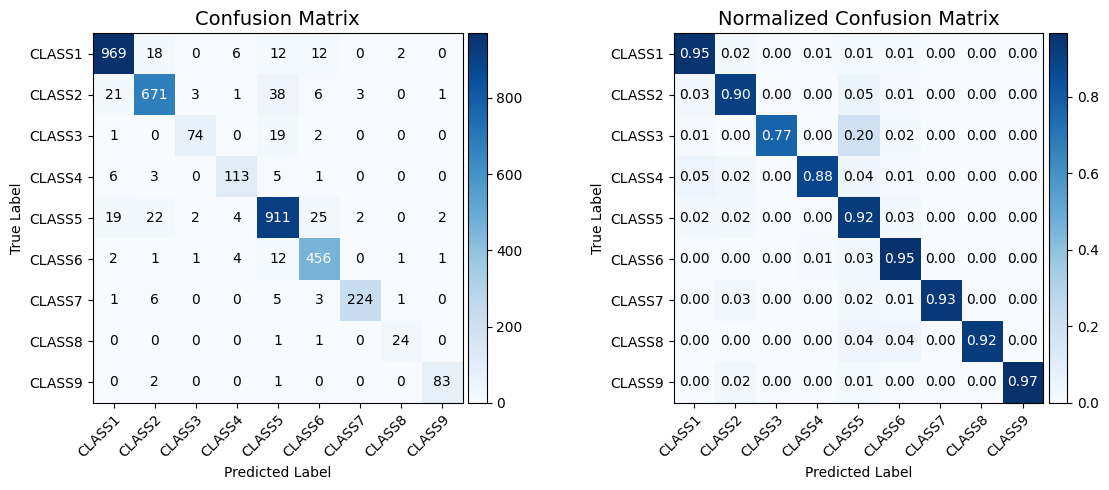

In [5]:
#Plot the confusion matrix and the confusion matrix normalized
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), layout='tight')
cm = confusion_matrix(y_test, predictions)

# --------------------------------------------------------------------- #
#Confusion matrix
im = ax[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax[0].figure.colorbar(im, ax=ax[0], pad=0.01)
class_names = sorted(np.unique(y_test))
ax[0].set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       )

ax[0].set_title(f'Confusion Matrix', fontsize=14) 
ax[0].set_xlabel('Predicted Label', fontsize = 10)
ax[0].set_ylabel('True Label', fontsize = 10)

# Rotate the tick labels and set their alignment
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = 400.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[0].text(j, i, format(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# --------------------------------------------------------------------- #
#Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
im = ax[1].imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax[1].figure.colorbar(im, ax=ax[1], pad=0.01)
class_names = sorted(np.unique(y_test))

ax[1].set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       )

ax[1].set_title(f'Normalized Confusion Matrix', fontsize=14) 
ax[1].set_xlabel('Predicted Label', fontsize = 10)
ax[1].set_ylabel('True Label', fontsize = 10)

# Rotate the tick labels and set their alignment
plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
fmt = '.2f'
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax[1].text(j, i, format(cm_normalized[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")

fig.savefig(f"{git_repo.working_tree_dir}\\RF\\Outputs\\Confusion Matrix.jpeg", dpi=300, bbox_inches='tight')

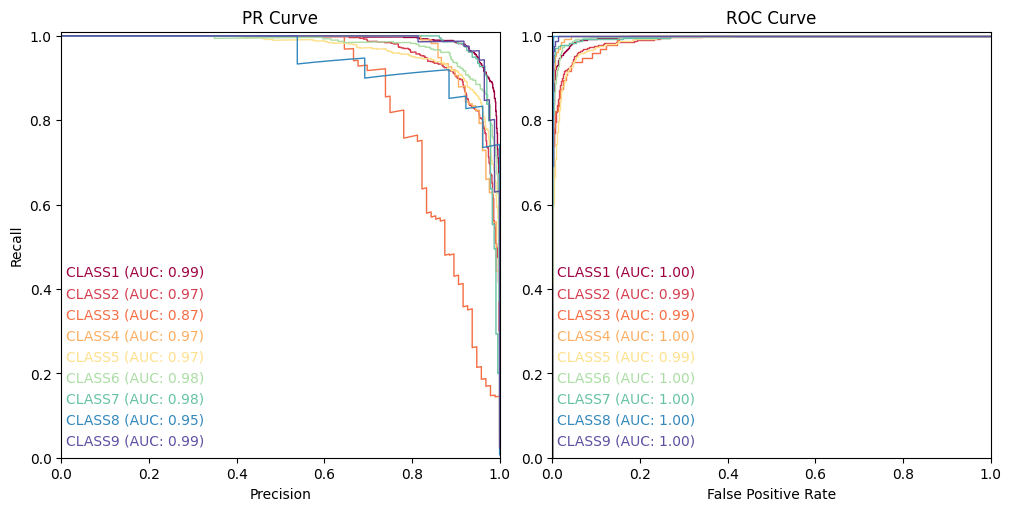

In [6]:
#Plot the PR-Curve and the ROC-Curve

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, average_precision_score

configs = {
    'CLASS1': {'color':'#9e0142', 'linestyle':'solid'},
    'CLASS2': {'color':'#d53e4f', 'linestyle':'solid'},
    'CLASS3': {'color':'#f46d43', 'linestyle':'solid'},
    'CLASS4': {'color':'#fdae61', 'linestyle':'solid'},
    'CLASS5': {'color':'#fee08b', 'linestyle':'solid'},
    'CLASS6': {'color':'#abdda4', 'linestyle':'solid'},
    'CLASS7': {'color':'#66c2a5', 'linestyle':'solid'},
    'CLASS8': {'color':'#3288bd', 'linestyle':'solid'},
    'CLASS9': {'color':'#5e4fa2', 'linestyle':'solid'},
}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), layout='constrained')

classes = np.unique(y)
n_classes = classes.shape[0]

#Transform the data to binary 
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

classifier = OneVsRestClassifier(model)
classifier.fit(x_train, y_train_bin)
y_score = classifier.predict_proba(x_test) #predictions


#PR-CURVE
precision = dict()
recall = dict()
pr_auc_dic = dict()

#ROC_CURVE
fpr = dict()
tpr = dict()
roc_auc_dic = dict()

for i in range(n_classes):
    classe = classes[i]

    #PR CURVE
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score[:, i])

    pr_auc_dic[classe] = auc(recall[i], precision[i])
    ax[0].plot(recall[i], precision[i], lw=1, color=configs[classe]['color'], linestyle=configs[classe]['linestyle'], label='class {}'.format(i))

    #ROC CURVE
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i],
                                  y_score[:, i])

    roc_auc_dic[classe] = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    ax[1].plot(fpr[i], tpr[i], lw=1, color=configs[classe]['color'], linestyle=configs[classe]['linestyle'], label='class {}'.format(i))

#AX[0] PR-Curve
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1.01)
ax[0].set_title(f'PR Curve', fontsize=12)
ax[0].set_xlabel('Precision', fontsize = 10)
ax[0].set_ylabel('Recall', fontsize = 10)

#AX[1] ROC-Curve
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1.01)
ax[1].set_title(f'ROC Curve', fontsize=12)
ax[1].set_ylabel('', fontsize = 10) #True Positive Rate (Recall)
ax[1].set_xlabel('False Positive Rate', fontsize = 10)

y_coord = 0.43
for lith in pr_auc_dic.keys():
    pr_auc = pr_auc_dic[lith]
    roc_auc = roc_auc_dic[lith]

    ax[0].annotate(f'{lith} (AUC: {pr_auc:.2f})', xy=(0.01, y_coord), fontsize=10, color=configs[lith]['color'])
    ax[1].annotate(f'{lith} (AUC: {roc_auc:.2f})', xy=(0.01, y_coord), fontsize=10, color=configs[lith]['color'])
    y_coord -= 0.05

fig.savefig(f"{git_repo.working_tree_dir}\\RF\\Outputs\\PR-ROC_Curves.jpeg", dpi=300, bbox_inches='tight')